# Facies classification using Convolutional Neural Networks #
## Team StoDIG  - Statoil Deep-learning Interest Group ##
### _[David Wade](https://no.linkedin.com/in/david-wade-79918023), [John Thurmond](https://www.linkedin.com/in/john-thurmond-098b774) & [Eskil Kulseth Dahl](https://www.linkedin.com/in/eskil-k-dahl-87a94679)_###

In this python notebook we propose a facies classification model, building on the simple Neural Network solution proposed by LA_Team in order to outperform the prediction model proposed in the [predicting facies from well logs challenge](https://github.com/seg/2016-ml-contest). 

Given the limited size of the training data set, Deep Learning is not likely to exceed the accuracy of results from refined Machine Learning techniques (such as Gradient Boosted Trees).  However, we chose to use the opportunity to advance our understanding of Deep Learning network design, and have enjoyed participating in the contest.  With a substantially larger training set and perhaps more facies ambiguity, Deep Learning could be a preferred approach to this sort of problem.


We use three key innovations:
 - Augmenting the input data with 1st and 2nd order derivatives
 - Inserting a convolutional layer as the first layer in the Neural Network
 - Adding Dropout regularization to prevent overfitting

## Problem Modeling
----

The dataset we will use comes from a class excercise from The University of Kansas on [Neural Networks and Fuzzy Systems](http://www.people.ku.edu/~gbohling/EECS833/).  This exercise is based on a consortium project to use machine learning techniques to create a reservoir model of the largest gas fields in North America, the Hugoton and Panoma Fields. For more info on the origin of the data, see [Bohling and Dubois (2003)](http://www.kgs.ku.edu/PRS/publication/2003/ofr2003-50.pdf) and [Dubois et al. (2007)](http://dx.doi.org/10.1016/j.cageo.2006.08.011). 

The dataset we will use is log data from nine wells that have been labeled with a facies type based on oberservation of core.  We will use this log data to train a classifier to predict facies types. 

This data is from the Council Grove gas reservoir in Southwest Kansas.  The Panoma Council Grove Field is predominantly a carbonate gas reservoir encompassing 2700 square miles in Southwestern Kansas.  This dataset is from nine wells (with 4149 examples), consisting of a set of seven predictor variables and a rock facies (class) for each example vector and validation (test) data (830 examples from two wells) having the same seven predictor variables in the feature vector.  Facies are based on examination of cores from nine wells taken vertically at half-foot intervals. Predictor variables include five from wireline log measurements and two geologic constraining variables that are derived from geologic knowledge. These are essentially continuous variables sampled at a half-foot sample rate. 

The seven predictor variables are:
* Five wire line log curves include [gamma ray](http://petrowiki.org/Gamma_ray_logs) (GR), [resistivity logging](http://petrowiki.org/Resistivity_and_spontaneous_%28SP%29_logging) (ILD_log10),
[photoelectric effect](http://www.glossary.oilfield.slb.com/en/Terms/p/photoelectric_effect.aspx) (PE), [neutron-density porosity difference and average neutron-density porosity](http://petrowiki.org/Neutron_porosity_logs) (DeltaPHI and PHIND). Note, some wells do not have PE.
* Two geologic constraining variables: nonmarine-marine indicator (NM_M) and relative position (RELPOS)

The nine discrete facies (classes of rocks) are: 
1. Nonmarine sandstone
2. Nonmarine coarse siltstone 
3. Nonmarine fine siltstone 
4. Marine siltstone and shale 
5. Mudstone (limestone)
6. Wackestone (limestone)
7. Dolomite
8. Packstone-grainstone (limestone)
9. Phylloid-algal bafflestone (limestone)

These facies aren't discrete, and gradually blend into one another. Some have neighboring facies that are rather close.  Mislabeling within these neighboring facies can be expected to occur.  The following table lists the facies, their abbreviated labels and their approximate neighbors.

Facies |Label| Adjacent Facies
:---: | :---: |:--:
1 |SS| 2
2 |CSiS| 1,3
3 |FSiS| 2
4 |SiSh| 5
5 |MS| 4,6
6 |WS| 5,7
7 |D| 6,8
8 |PS| 6,7,9
9 |BS| 7,8

## Setup
---

Check we have all the libraries we need, and import the modules we require. Note that we have used the Theano backend for Keras, and to achieve a reasonable training time we have used an NVidia K20 GPU.

In [1]:
%%sh
pip install pandas
pip install scikit-learn
pip install keras
pip install sklearn

In [2]:
from __future__ import print_function
import time
import numpy as np
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.optimizers import Adamax
from keras.optimizers import Nadam
from keras.layers import Dense, Dropout, Activation, Convolution1D, Flatten, Reshape, MaxPooling1D, GaussianNoise
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold , StratifiedKFold
from classification_utilities import display_cm, display_adj_cm
from sklearn.metrics import confusion_matrix, f1_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

Using Theano backend.
Using gpu device 0: Tesla K20c (CNMeM is enabled with initial size: 20.0% of memory, cuDNN 5105)
/home/dawad/anaconda3/lib/python3.5/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


## Data ingest
---
We load the training and testing data to preprocess it for further analysis, filling the missing data values in the PE field with zero and proceeding to normalize the data that will be fed into our model.

In [3]:
filename = 'train_test_data.csv'
data = pd.read_csv(filename)
data.head(12)

# Set 'Well Name' and 'Formation' fields as categories
data['Well Name'] = data['Well Name'].astype('category')
data['Formation'] = data['Formation'].astype('category')

# Fill missing values and normalize for 'PE' field
data['PE'] = data['PE'].fillna(value=0)
mean_pe = data['PE'].mean()
std_pe = data['PE'].std()
data['PE'] = (data['PE']-mean_pe)/std_pe

# Normalize the rest of fields (GR, ILD_log10, DelthaPHI, PHIND,NM_M,RELPOS)
correct_facies_labels = data['Facies'].values
feature_vectors = data.drop(['Formation'], axis=1)
well_labels = data[['Well Name', 'Facies']].values
data_vectors = feature_vectors.drop(['Well Name', 'Facies'], axis=1).values
scaler = preprocessing.StandardScaler().fit(data_vectors)
scaled_features = scaler.transform(data_vectors)
data_out = np.hstack([well_labels, scaled_features])

Split data into training data and blind data, and output as Numpy arrays

In [4]:
def preprocess(data_out):
    
    data = data_out
    well_data = {}
    well_names = ['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', 'KIMZEY A', 'CROSS H CATTLE', 
                  'NOLAN', 'Recruit F9', 'NEWBY', 'CHURCHMAN BIBLE', 'STUART', 'CRAWFORD']
    for name in well_names:
        well_data[name] = [[], []]

    for row in data:
        well_data[row[0]][1].append(row[1])
        well_data[row[0]][0].append(list(row[2::]))

    chunks = []
    chunks_test = []
    chunk_length = 1 
    chunks_facies = []
    wellID=0.0
    for name in well_names:
        
        if name not in ['STUART', 'CRAWFORD']:
            test_well_data = well_data[name]
            log_values = np.array(test_well_data[0])
            facies_values =  np.array(test_well_data[1])
            for i in range(log_values.shape[0]):
                toAppend = np.concatenate((log_values[i:i+1, :], np.asarray(wellID).reshape(1,1)), axis=1)
                chunks.append(toAppend)
                chunks_facies.append(facies_values[i])
        else:
            test_well_data = well_data[name]
            log_values = np.array(test_well_data[0])
            for i in range(log_values.shape[0]):
                toAppend = np.concatenate((log_values[i:i+1, :], np.asarray(wellID).reshape(1,1)), axis=1)
                chunks_test.append(toAppend)
        
        wellID = wellID + 1.0
    
    chunks_facies = np.array(chunks_facies, dtype=np.int32)-1
    X_ = np.array(chunks)
    X = np.zeros((len(X_),len(X_[0][0]) * len(X_[0])))
    for i in range(len(X_)):
        X[i,:] = X_[i].flatten()
        
    X_test = np.array(chunks_test)
    X_test_out = np.zeros((len(X_test),len(X_test[0][0]) * len(X_test[0])))
    for i in range(len(X_test)):
        X_test_out[i,:] = X_test[i].flatten()
    y = np_utils.to_categorical(chunks_facies)
    return X, y, X_test_out

X_train_in, y_train, X_test_in = preprocess(data_out)

## Data Augmentation
---

It is physically reasonable to expect 1st and 2nd order derivatives of logs to play an important role in determining facies. To save the CNN the effort of learning convolution kernels to represent these features to the rest of the Neural Network we compute them here (for training and validation data). Further, we expand the input data to be acted on by the convolutional layer.

In [5]:
conv_length = 7

# Reproducibility
np.random.seed(7) 
# Load data

def addGradients(input):
    output = input
    for i in range(8):
        grad    = np.gradient(output[:,i])
        gradT   = np.reshape(grad,(grad.size,1))
        output  = np.concatenate((output, gradT), axis=1)

        grad2   = np.gradient(grad)
        grad2T  = np.reshape(grad2,(grad2.size,1))
        output  = np.concatenate((output, grad2T), axis=1)

    return output


def expand_dims(input):
    r = int((conv_length-1)/2)
    l = input.shape[0]
    n_input_vars = input.shape[1]
    output = np.zeros((l, conv_length, n_input_vars))
    for i in range(l):
        for j in range(conv_length):
            for k in range(n_input_vars):
                output[i,j,k] = input[min(i+j-r,l-1),k]
    return output

X_train = np.empty((0,conv_length,24), dtype=float)
X_test  = np.empty((0,conv_length,24), dtype=float)

wellId = 0.0
for i in range(10):
    X_train_subset = X_train_in[X_train_in[:, 8] == wellId][:,0:8]
    X_train_subset = addGradients(X_train_subset)
    X_train_subset = expand_dims(X_train_subset)
    X_train = np.concatenate((X_train,X_train_subset),axis=0)
    wellId = wellId + 1.0
    
for i in range(2):
    X_test_subset = X_test_in[X_test_in[:, 8] == wellId][:,0:8]
    X_test_subset = addGradients(X_test_subset)
    X_test_subset = expand_dims(X_test_subset)
    X_test = np.concatenate((X_test,X_test_subset),axis=0)
    wellId = wellId + 1.0
    
print(X_train.shape)
print(X_test.shape)

# Obtain labels
y_labels = np.zeros((len(y_train),1))
for i in range(len(y_train)):
    y_labels[i] = np.argmax(y_train[i])
y_labels = y_labels.astype(int)

(4149, 7, 24)
(830, 7, 24)


### Convolutional Neural Network
#### We build a CNN with the following layers:
 - Dropout layer on input
 - One 1D convolutional layer, with MaxPooling
 - Series of Dropout & Fully-Connected layers, of parameterizable length

In [6]:
# Set parameters
input_dim = 24
output_dim = 9
n_per_batch = 128
epochs = 200

def dnn_model(init_dropout_rate=0.5, main_dropout_rate=0.45, hidden_dim_1=192, hidden_dim_2=96, max_norm=10, n_dense=3, sigma=0.0, nb_conv=32):
    # Define the model
    model = Sequential()
    model.add(Dropout(init_dropout_rate, input_shape=(conv_length,input_dim,)))
    model.add(Convolution1D(nb_conv, conv_length, border_mode='same', activation='relu', input_shape=(conv_length,input_dim), input_length=conv_length))
    model.add(MaxPooling1D(pool_length=2, stride=None, border_mode='same'))
    model.add(Flatten())
    model.add(Dropout(main_dropout_rate, input_shape=(nb_conv*conv_length,)))
    model.add(Dense(hidden_dim_1, input_dim=nb_conv*conv_length, init='uniform', activation='relu', W_constraint=maxnorm(max_norm)))
    for i in range(n_dense):
        if (i==1):          
            model.add(Dropout(main_dropout_rate, input_shape=(hidden_dim_1,)))
            model.add(Dense(hidden_dim_2, input_dim=hidden_dim_1, init='uniform', activation='relu', W_constraint=maxnorm(max_norm)))
        else:
            model.add(Dropout(main_dropout_rate, input_shape=(hidden_dim_2,)))
            model.add(Dense(hidden_dim_2, input_dim=hidden_dim_2, init='uniform', activation='relu', W_constraint=maxnorm(max_norm)))
    model.add(Dense(output_dim, init='normal', activation='softmax'))
    
    optimizerNadam = Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
    model.compile(loss='categorical_crossentropy', optimizer=optimizerNadam, metrics=['accuracy'])
    return model

#### We train the CNN and evaluate it on precision/recall.

In [34]:
# Load the model
t0 = time.time()
model_dnn = dnn_model()
model_dnn.summary()
t1 = time.time()
print("Load time = %d" % (t1-t0) )

#Train model
t0 = time.time()
model_dnn.fit(X_train, y_train, batch_size=n_per_batch, nb_epoch=epochs, verbose=0)
t1 = time.time()
print("Train time = %d seconds" % (t1-t0) )


# Predict Values on Training set
t0 = time.time()
y_predicted = model_dnn.predict( X_train , batch_size=n_per_batch, verbose=2)
t1 = time.time()
print("Test time = %d seconds" % (t1-t0) )

# Print Report

# Format output [0 - 8 ]
y_ = np.zeros((len(y_train),1))
for i in range(len(y_train)):
    y_[i] = np.argmax(y_train[i])

y_predicted_ = np.zeros((len(y_predicted), 1))
for i in range(len(y_predicted)):
    y_predicted_[i] = np.argmax( y_predicted[i] )
    
# Confusion Matrix
conf = confusion_matrix(y_, y_predicted_)

def accuracy(conf):
    total_correct = 0.
    nb_classes = conf.shape[0]
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
    acc = total_correct/sum(sum(conf))
    return acc

adjacent_facies = np.array([[1], [0,2], [1], [4], [3,5], [4,6,7], [5,7], [5,6,8], [6,7]])
facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS','WS', 'D','PS', 'BS']

def accuracy_adjacent(conf, adjacent_facies):
    nb_classes = conf.shape[0]
    total_correct = 0.
    for i in np.arange(0,nb_classes):
        total_correct += conf[i][i]
        for j in adjacent_facies[i]:
            total_correct += conf[i][j]
    return total_correct / sum(sum(conf))

# Print Results
print ("\nModel Report")
print ("-Accuracy: %.6f" % ( accuracy(conf) ))
print ("-Adjacent Accuracy: %.6f" % ( accuracy_adjacent(conf, adjacent_facies) ))
print ("\nConfusion Matrix")
display_cm(conf, facies_labels, display_metrics=True, hide_zeros=True)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dropout_131 (Dropout)            (None, 7, 24)         0           dropout_input_27[0][0]           
____________________________________________________________________________________________________
convolution1d_27 (Convolution1D) (None, 7, 32)         5408        dropout_131[0][0]                
____________________________________________________________________________________________________
maxpooling1d_27 (MaxPooling1D)   (None, 4, 32)         0           convolution1d_27[0][0]           
____________________________________________________________________________________________________
flatten_27 (Flatten)             (None, 128)           0           maxpooling1d_27[0][0]            
___________________________________________________________________________________________

#### We display the learned 1D convolution kernels

(7, 1, 24, 32)


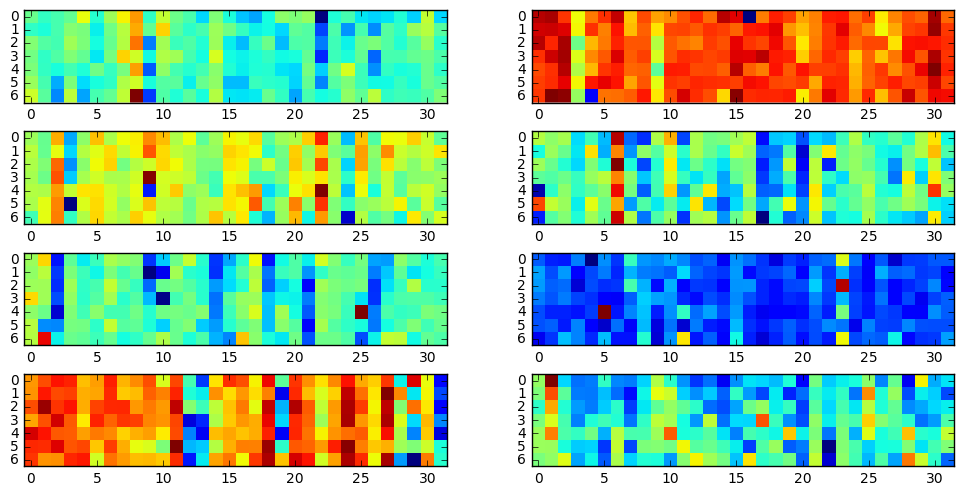

In [36]:
print(model_dnn.layers[1].get_weights()[0].shape)

fig, ax = plt.subplots(figsize=(12,6))

plt.subplot(421)
plt.imshow(model_dnn.layers[1].get_weights()[0][:,0,0,:], interpolation='none')
plt.subplot(422)
plt.imshow(model_dnn.layers[1].get_weights()[0][:,0,1,:], interpolation='none')
plt.subplot(423)
plt.imshow(model_dnn.layers[1].get_weights()[0][:,0,2,:], interpolation='none')
plt.subplot(424)
plt.imshow(model_dnn.layers[1].get_weights()[0][:,0,3,:], interpolation='none')
plt.subplot(425)
plt.imshow(model_dnn.layers[1].get_weights()[0][:,0,4,:], interpolation='none')
plt.subplot(426)
plt.imshow(model_dnn.layers[1].get_weights()[0][:,0,5,:], interpolation='none')
plt.subplot(427)
plt.imshow(model_dnn.layers[1].get_weights()[0][:,0,6,:], interpolation='none')
plt.subplot(428)
plt.imshow(model_dnn.layers[1].get_weights()[0][:,0,7,:], interpolation='none')

plt.show()

#### In order to avoid overfitting, we evaluate our model by running a 5-fold stratified cross-validation routine.

In [39]:
# Cross Validation
def cross_validate():
    t0 = time.time()
    estimator = KerasClassifier(build_fn=dnn_model, nb_epoch=epochs, batch_size=n_per_batch, verbose=0)
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    results_dnn = cross_val_score(estimator, X_train, y_train, cv= skf.get_n_splits(X_train, y_train))
    t1 = time.time()
    print("Cross Validation time = %d" % (t1-t0) )
    print(' Cross Validation Results')
    print( results_dnn )
    print(np.mean(results_dnn))

cross_validate()

Cross Validation time = 187
 Cross Validation Results
[ 0.56385542  0.53975903  0.54578313  0.45421687  0.52472859]
0.525668608609


## Prediction
---
To predict the STUART and CRAWFORD blind wells we do the following:

#### Set up a plotting function to display the logs & facies.

In [40]:
# 1=sandstone  2=c_siltstone   3=f_siltstone 
# 4=marine_silt_shale 5=mudstone 6=wackestone 7=dolomite
# 8=packstone 9=bafflestone
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

#facies_color_map is a dictionary that maps facies labels
#to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]

def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.Depth, '-g')
    ax[1].plot(logs.ILD_log10, logs.Depth, '-')
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.PHIND, logs.Depth, '-', color='r')
    ax[4].plot(logs.PE, logs.Depth, '-', color='black')
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((17*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

#### Run the model on the blind data
 - Output a CSV
 - Plot the wells in the notebook

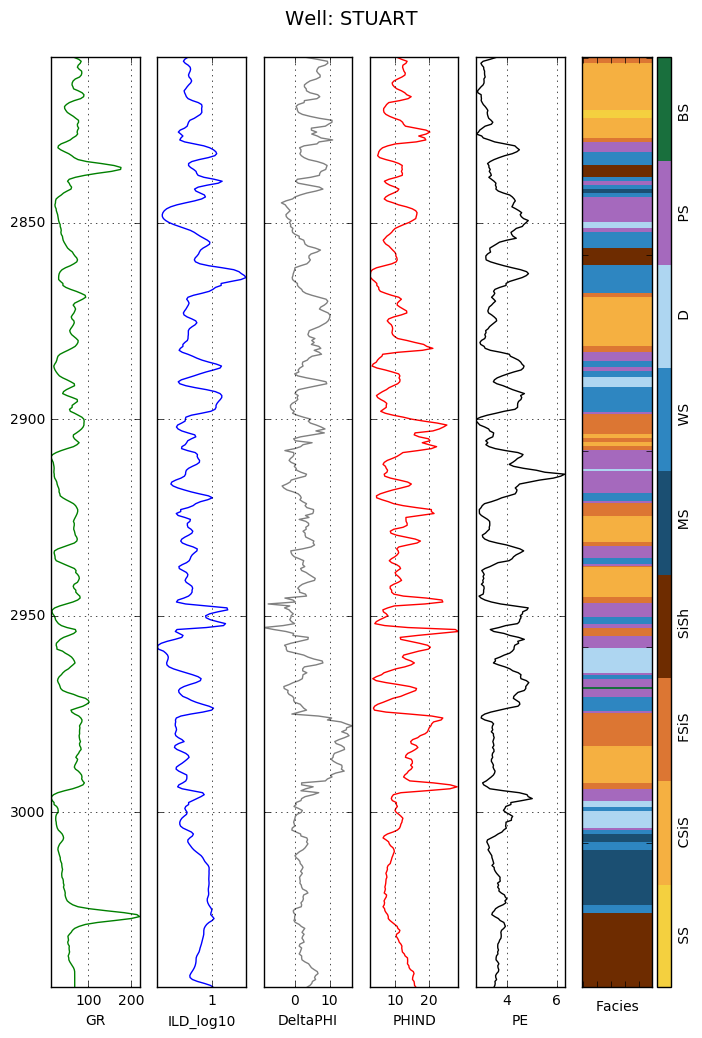

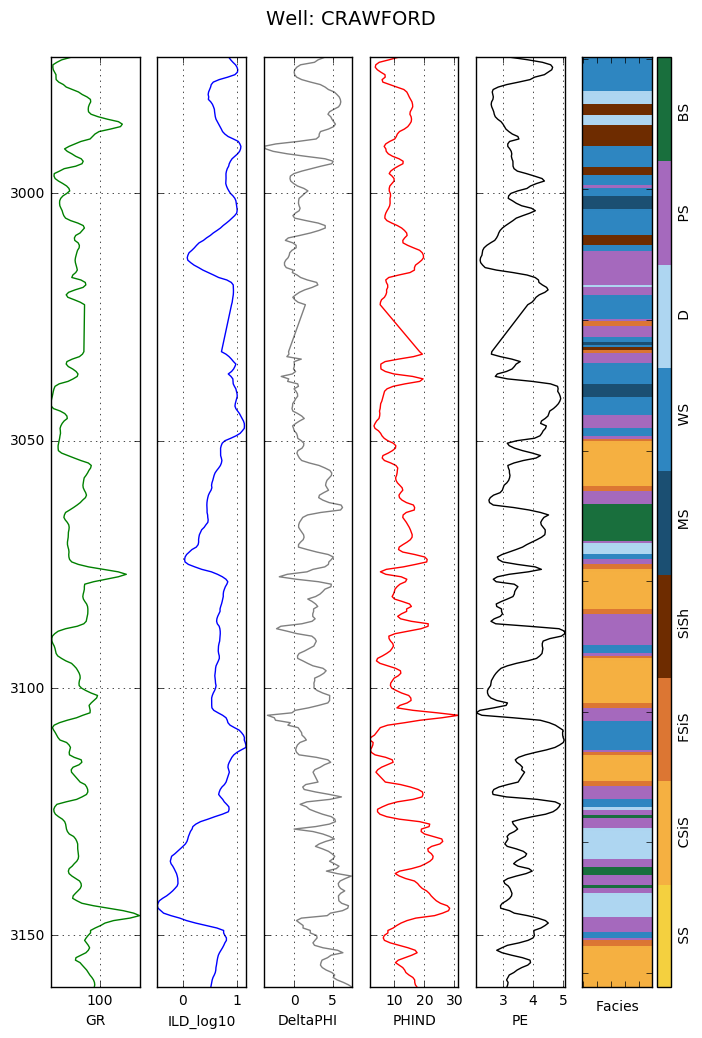

In [41]:
# DNN model Prediction
y_test = model_dnn.predict( X_test , batch_size=n_per_batch, verbose=0)
predictions_dnn = np.zeros((len(y_test),1))
for i in range(len(y_test)):
    predictions_dnn[i] = np.argmax(y_test[i]) + 1 
predictions_dnn = predictions_dnn.astype(int)
# Store results
test_data = pd.read_csv('../validation_data_nofacies.csv')
test_data['Facies'] = predictions_dnn
test_data.to_csv('Prediction_StoDIG.csv')

make_facies_log_plot(
    test_data[test_data['Well Name'] == 'STUART'],
    facies_colors=facies_colors)

make_facies_log_plot(
    test_data[test_data['Well Name'] == 'CRAWFORD'],
    facies_colors=facies_colors)